In [9]:
import os

# essentials
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# tensorflow tools
import keras
from keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from keras.applications.xception import Xception, preprocess_input as xception_preprocess
from keras.preprocessing import image
from keras import Model
from keras.layers import Dense, Flatten

In [2]:
base_dir = './data/Fruits-360/fruits-360_dataset/fruits-360'

train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

In [3]:
label_list = os.listdir(test_dir)

In [4]:
label_list

['Apple Braeburn',
 'Apple Crimson Snow',
 'Apple Golden 1',
 'Apple Golden 2',
 'Apple Golden 3',
 'Apple Granny Smith',
 'Apple Pink Lady',
 'Apple Red 1',
 'Apple Red 2',
 'Apple Red 3',
 'Apple Red Delicious',
 'Apple Red Yellow 1',
 'Apple Red Yellow 2',
 'Apricot',
 'Avocado',
 'Avocado ripe',
 'Banana',
 'Banana Lady Finger',
 'Banana Red',
 'Beetroot',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe 1',
 'Cantaloupe 2',
 'Carambula',
 'Cauliflower',
 'Cherry 1',
 'Cherry 2',
 'Cherry Rainier',
 'Cherry Wax Black',
 'Cherry Wax Red',
 'Cherry Wax Yellow',
 'Chestnut',
 'Clementine',
 'Cocos',
 'Corn',
 'Corn Husk',
 'Cucumber Ripe',
 'Cucumber Ripe 2',
 'Dates',
 'Eggplant',
 'Fig',
 'Ginger Root',
 'Granadilla',
 'Grape Blue',
 'Grape Pink',
 'Grape White',
 'Grape White 2',
 'Grape White 3',
 'Grape White 4',
 'Grapefruit Pink',
 'Grapefruit White',
 'Guava',
 'Hazelnut',
 'Huckleberry',
 'Kaki',
 'Kiwi',
 'Kohlrabi',
 'Kumquats',
 'Lemon',
 'Lemon Meyer',
 'Limes',
 'Lychee',
 'M

In [5]:
# image_size = (224, 224)
batch_size = 32
num_classes = len(label_list)

In [242]:
train_datagen = image.ImageDataGenerator(
    validation_split=0.2,
    rotation_range=180,
    shear_range=10,
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = image.ImageDataGenerator()

In [243]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    batch_size=1,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_gen = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_gen = train_datagen.flow_from_directory(
    test_dir,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 54190 images belonging to 131 classes.


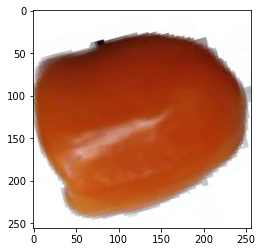

In [300]:
sample_image = train_gen.next()
x, y = sample_image
plt.imshow(x[0])